# Create point cloud using multiple images
Leverage what we learned in EssentialMatrix_StereoReconstruction.ipynb and chain together multiple views to generate a more extensive 3d model

https://docs.opencv.org/4.3.0/da/de9/tutorial_py_epipolar_geometry.html

In [15]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

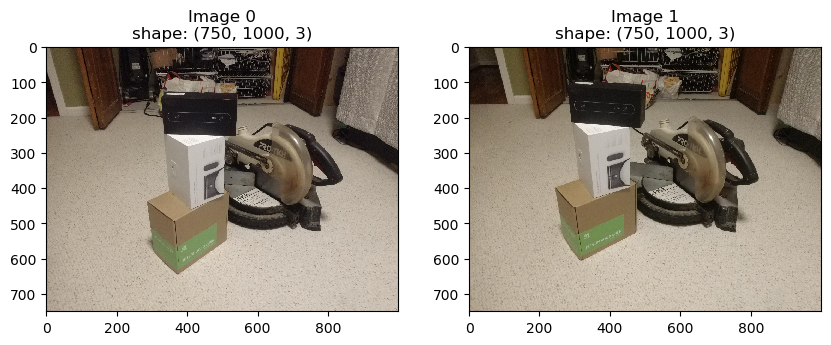

In [31]:
plt.rcParams["figure.figsize"] = [10,10]
# load images
image_dir = "images/saw"
image_scale = .25
images = [cv2.imread(os.path.join(image_dir,fname)) for fname in sorted(os.listdir(image_dir))]
images = [cv2.resize(image,(0,0),fx=image_scale,fy=image_scale) for image in images]
plt.subplot(2,2,1)
plt.title(f"Image 0\nshape: {image_left.shape}")
plt.imshow(images[0][:,:,::-1])
plt.subplot(2,2,2)
plt.title(f"Image 1\nshape: {image_right.shape}")
plt.imshow(images[1][:,:,::-1])
plt.show()

parameter_filename = f"camera_parameters_scale{image_scale:.4f}.json"
with open(parameter_filename,'r') as fp:
    parameters = json.load(fp)

mtx = np.array(parameters['mtx'],dtype=np.float32)
newCameraMtx = np.array(parameters['newCameraMtx'],dtype=np.float32)
dist = np.array(parameters['dist'],dtype=np.float32)
roi = np.array(parameters['roi'],dtype=np.int32)

Found 257 matches from 1000
Found 140 matches from 1000
Found 214 matches from 1000
Found 114 matches from 1000


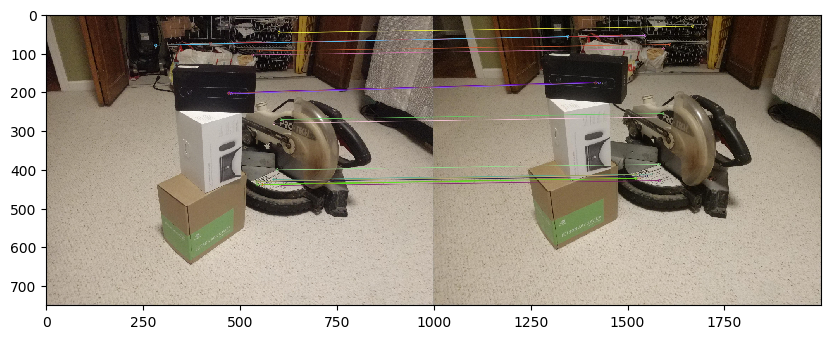

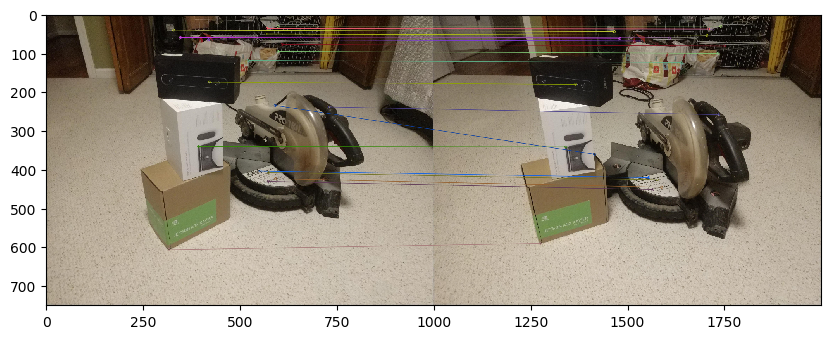

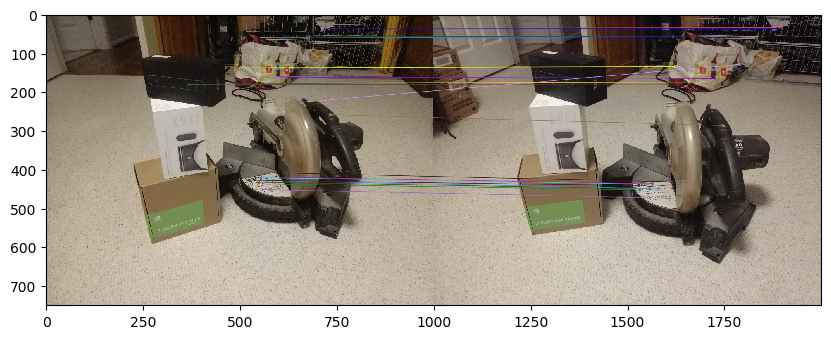

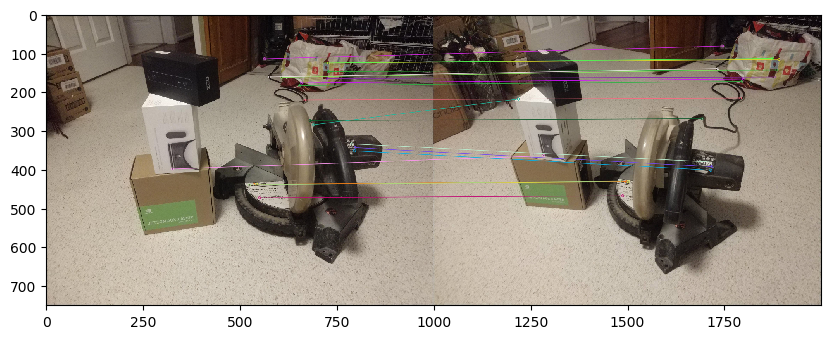

In [35]:
orb = cv2.ORB_create(nfeatures=1000)
kps = [] #holds keypoints for each image
descs = [] # holds descriptors for each image
for image in images:
    kp, desc = orb.detectAndCompute(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),None)
    kps.append(kp)
    descs.append(desc)


# Match descriptors
MIN_MATCH_COUNT = 10
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                  table_number =12, # 12
                  key_size = 10,     # 20
                  multi_probe_level = 2) #2
search_params = {"checks":100}
flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = [] #holds matches for image[idx](query) and image[idx+1](train)
pts = []
for idx in range(len(kps)-1):
    
    match = flann.knnMatch(descs[idx], descs[idx+1], k=2) # query is descs1 which is left image
    match_count = len(match)
    
    good_matches = []
    pt1 = []
    pt2 = []
    for i, (m,n) in enumerate(match):
        if m.distance < 0.8*n.distance:
            good_matches.append(m)
            pt2.append(kps[idx+1][m.trainIdx].pt)
            pt1.append(kps[idx][m.queryIdx].pt)
    matches.append(good_matches)
    pts.append([pt1,pt2])
    print(f"Found {len(good_matches)} matches from {match_count}")   

for ii in range(len(images)-1):
    img3 = cv2.drawMatches(images[ii],kps[ii], images[ii+1],kps[ii+1], matches[ii][:20],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3[:,:,::-1])
    plt.show()

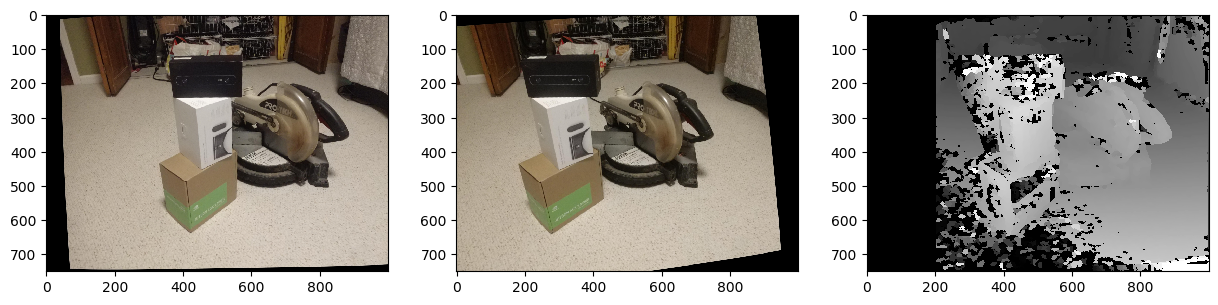

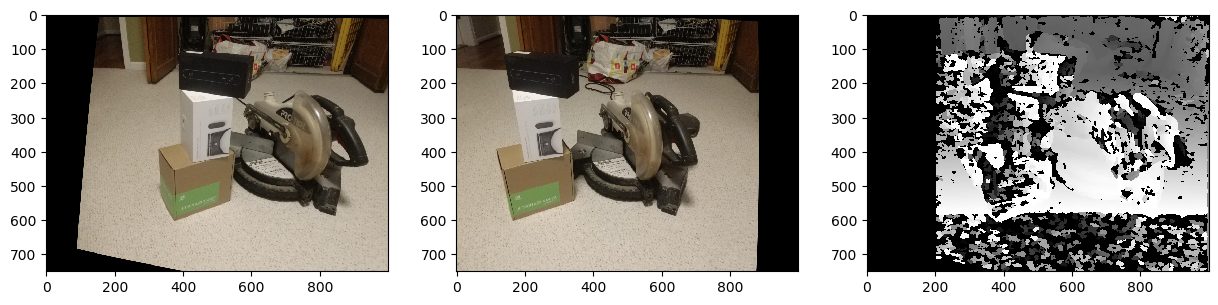

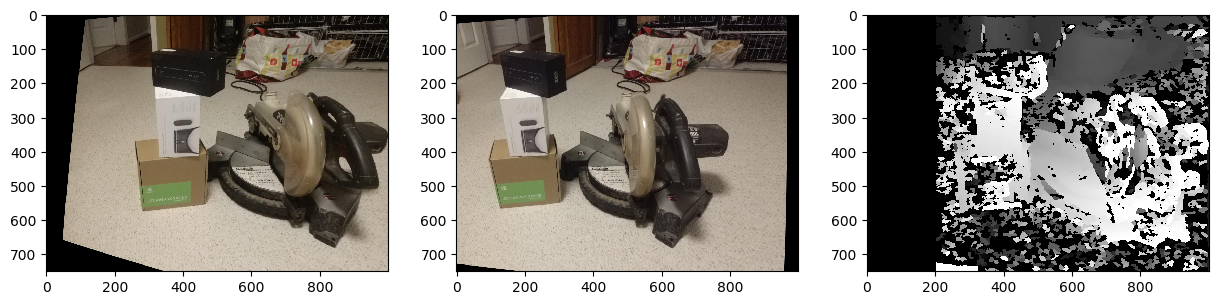

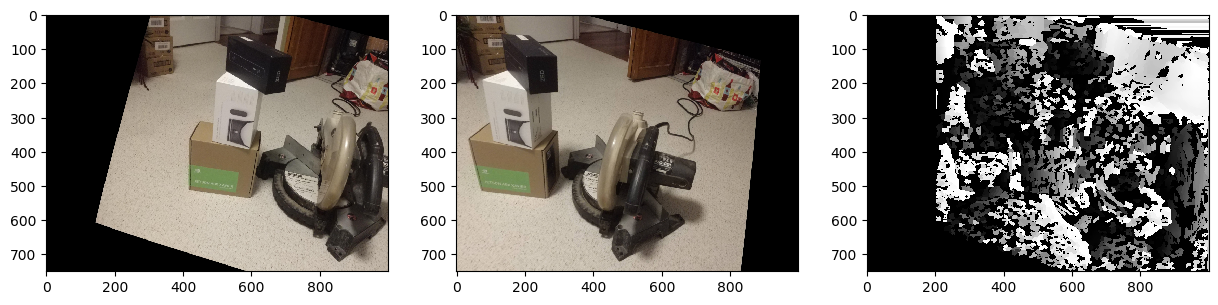

In [197]:
stereo = cv2.StereoSGBM_create(minDisparity=10,
                            numDisparities=12*16,
                            blockSize=13,
                            P1=200,
                            P2=900,
                            disp12MaxDiff=200,
                            #preFilterCap=1,
                            uniquenessRatio=2,
                            speckleWindowSize=140,
                            speckleRange=1)
images_rectified = []
disparities = []
Rs = []
Ts = []
Ps = []
Qs = []

for idx in range(len(images)-1):
    pts1 = np.array(pts[idx][0],dtype=np.int32)
    pts2 = np.array(pts[idx][1],dtype=np.int32)
    E, mask = cv2.findEssentialMat(pts1, pts2, mtx, cv2.FM_LMEDS)
    pts1_inliers = pts1[mask.ravel()==1]
    pts2_inliers = pts2[mask.ravel()==1]
    
    retval, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, mtx)    
    R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(mtx, dist, mtx, dist, images[0].shape[:2], R,t)
    mapx1,mapy1  = cv2.initUndistortRectifyMap(mtx, dist, R1, P1, shape, cv2.CV_32FC1)
    mapx2,mapy2  = cv2.initUndistortRectifyMap(mtx, dist, R2, P2, shape, cv2.CV_32FC1)
    image_left_rectified = cv2.remap(images[idx],mapx1,mapy1,cv2.INTER_LINEAR)
    image_right_rectified = cv2.remap(images[idx+1],mapx2,mapy2,cv2.INTER_LINEAR)
    disparity = stereo.compute(cv2.cvtColor(image_left_rectified,cv2.COLOR_BGR2GRAY),
                               cv2.cvtColor(image_right_rectified,cv2.COLOR_BGR2GRAY)).astype(np.float32)/16
    
    images_rectified.append([image_left_rectified,image_right_rectified])
    disparities.append(disparity)
    Rs.append(R)
    Ts.append(t)
    Ps.append([P1,P2])
    Qs.append(Q)
    
    plt.subplot(1,3,1)
    plt.imshow(image_left_rectified[:,:,::-1])
    plt.subplot(1,3,2)
    plt.imshow(image_right_rectified[:,:,::-1])
    plt.subplot(1,3,3)
    plt.imshow(disparity,cmap="gray")    
    plt.show()
    #break

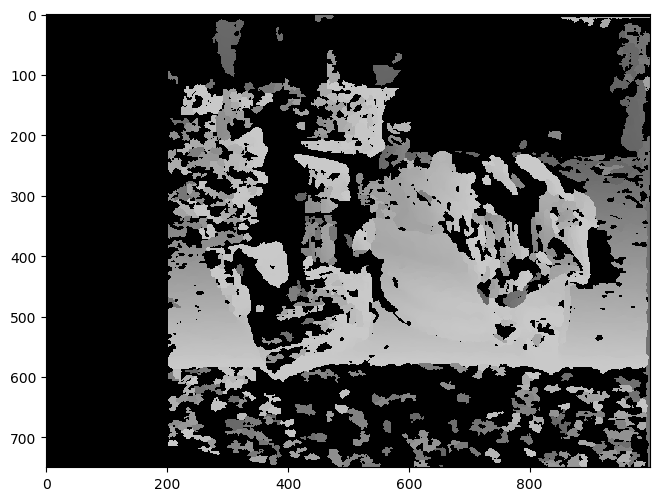

In [179]:
disparity = disparities[image_idx].copy()
disparity[disparity < 100] = 0
disparity[0] = 0
disparity[1] = 255
plt.imshow(disparity,cmap="gray")

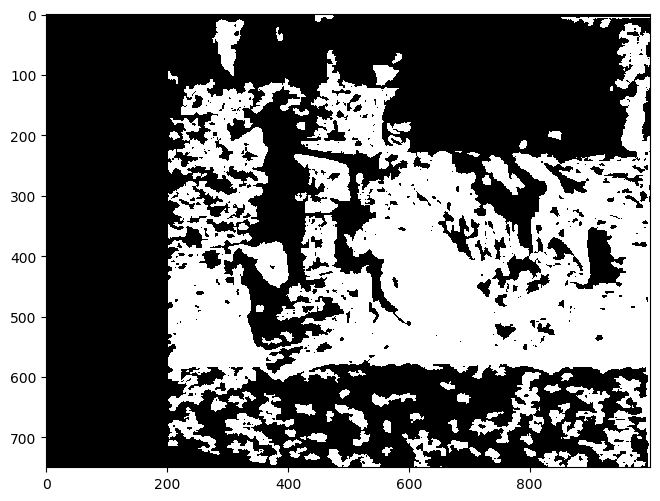

In [180]:
mask = disparities[image_idx]>disparities[image_idx].min()
mask = np.logical_and(mask, disparities[image_idx] > 100)
mask = mask.astype(np.uint8)
mask[0,0] = 0
mask[1,0] = 1
plt.imshow(mask,cmap="gray")

[11  0]


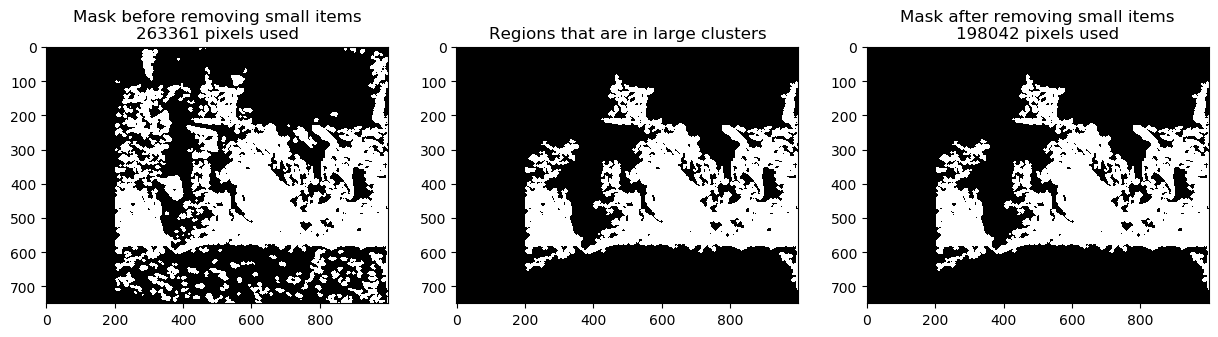

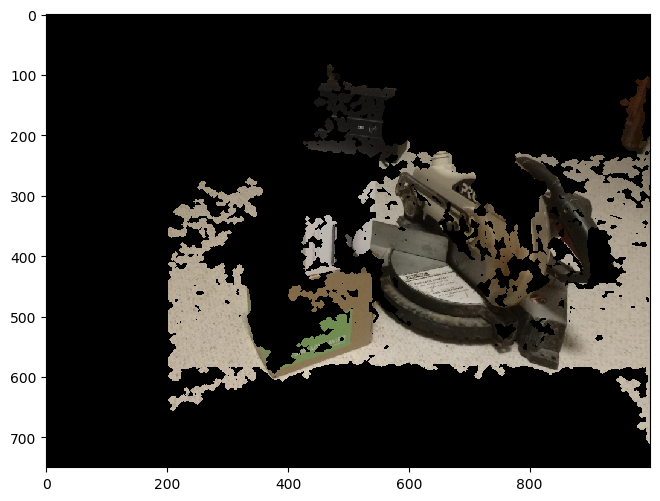

In [181]:
image_idx = 1

mask = disparities[image_idx]>disparities[image_idx].min()
mask = np.logical_and(mask, disparities[image_idx] > 100)# Remove the background
mask = mask.astype(np.uint8)

# combined goes to 318269

# Get rid of small items by themselves
# can help segment off regions connected by 1 pixel
mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)),iterations =3)


# by itself goes from 384675 to 346905
# Idea here is to find small connected components in the mask and remove them.
# The simplest thing to do is just keep the top few percent of clusters
#    other options like keeping below a specific size are useful as well
#    It may also be interesting to filter out clusters that are skinny, oblong, or have a large bounding box
#       but do not have many pixels in them
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask,connectivity=8)
sizes = stats[1:,-1]
nb_components = nb_components - 1

cluster_idx_sorted = np.argsort(stats[:,-1])
num_clusters = cluster_idx_sorted.shape[0]
num_clusters_to_keep = max(int(num_clusters*.002),2) # always keep at least 1
clusters_to_keep = cluster_idx_sorted[-num_clusters_to_keep:]
print(clusters_to_keep)

cluster_mask = np.zeros_like(mask)
for cluster_id in clusters_to_keep:
    if cluster_id == 0: #cluster 0 is always the background
        continue
    cluster_mask[output == cluster_id] = 1
    

plt.rcParams['figure.figsize'] = [15,6]
plt.subplot(1,3,1)
plt.title(f"Mask before removing small items\n{np.sum(mask)} pixels used")
plt.imshow(mask,cmap="gray")

plt.subplot(1,3,2)
plt.title(f"Regions that are in large clusters")
plt.imshow(cluster_mask,cmap="gray")


mask = mask.astype(np.bool)
mask = np.logical_and(mask, cluster_mask)
l = np.zeros_like(image_left_rectified)
l[mask] = images_rectified[image_idx][0][mask]

plt.subplot(1,3,3)
plt.title(f"Mask after removing small items\n{np.sum(mask)} pixels used")
plt.imshow(mask,cmap="gray")
plt.show()
plt.rcParams = plt.rcParamsDefault

plt.imshow(l[:,:,::-1])
plt.show()

In [182]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [183]:
# Reproject the verticies to 3d, get the colors correct as well
verticies = cv2.reprojectImageTo3D(disparities[image_idx],Qs[image_idx])
colors = cv2.cvtColor(images_rectified[image_idx][0],cv2.COLOR_BGR2RGB)

In [184]:
# This allows us to only export the values we are interested in, instead of a bunch of points at 0
mask_3d = np.repeat(np.expand_dims(mask,axis=-1),3,axis=-1)
mask_3d_inverted = np.logical_not(mask_3d) # masked arrays have mask==1 when not using value
verticies = np.ma.masked_array(verticies, mask=mask_3d_inverted).compressed()
colors = np.ma.masked_array(colors, mask=mask_3d_inverted).compressed()

write_ply(f"saw_{image_idx:02d}_{image_idx+1:02d}.ply",verticies,colors)

In [191]:
Ts[0][0]

array([-0.99129618])

In [198]:
Rs[0]

array([[ 0.99000875, -0.06661713,  0.12427722],
       [ 0.06865298,  0.99756641, -0.01216672],
       [-0.12316427,  0.02057716,  0.99217294]])

In [207]:
Rt0 = np.hstack((Rs[0], Ts[0]))
Rt1 = np.hstack((Rs[1], Ts[1]))

np.matmul(Rt1.T,Rt0)

array([[ 0.99407109,  0.0222124 , -0.10643908, -0.98912638],
       [-0.02379211,  0.99962449, -0.01359457, -0.01055905],
       [ 0.10609715,  0.01604638,  0.99422629, -0.14668847],
       [-0.99300345,  0.07347906, -0.09243902,  0.99276048]])

In [203]:
Ps[0][1]

array([[ 796.28613281,    0.        ,  501.12487984, -796.28613281],
       [   0.        ,  796.28613281,  361.05928421,    0.        ],
       [   0.        ,    0.        ,    1.        ,    0.        ]])